In [ ]:
# prompt: create "dataset" folder and move train and test folder to it

import os
import shutil

# Create the 'dataset' directory if it doesn't exist
dataset_dir = 'dataset'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Move 'train' and 'test' directories to the 'dataset' directory
for folder in ['TRAIN', 'TEST']:
  source_path = folder
  destination_path = os.path.join(dataset_dir, folder)

  if os.path.exists(source_path):
      shutil.move(source_path, destination_path)
      print(f"Moved '{folder}' to '{dataset_dir}'")
  else:
      print(f"Directory '{folder}' not found")

Moved 'TRAIN' to 'dataset'
Moved 'TEST' to 'dataset'


In [ ]:
import os
dataset_path = "/content/dataset/TRAIN"
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}, Subdirs: {dirs}, Files: {len(files)}")

Root: /content/dataset/TRAIN, Subdirs: ['Caries', 'Gingivitis'], Files: 0
Root: /content/dataset/TRAIN/Caries, Subdirs: [], Files: 744
Root: /content/dataset/TRAIN/Gingivitis, Subdirs: [], Files: 742


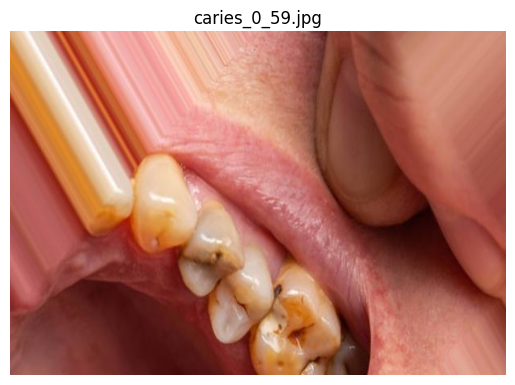

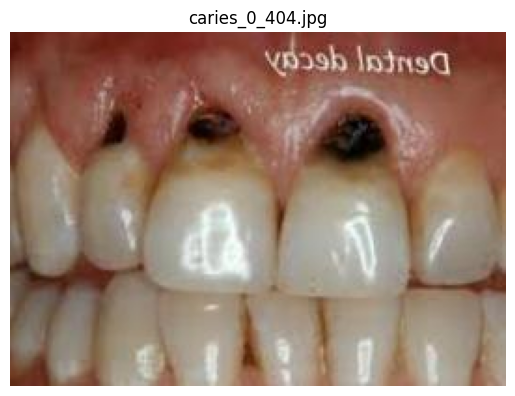

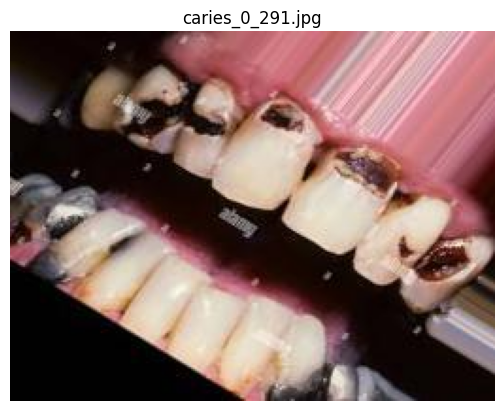

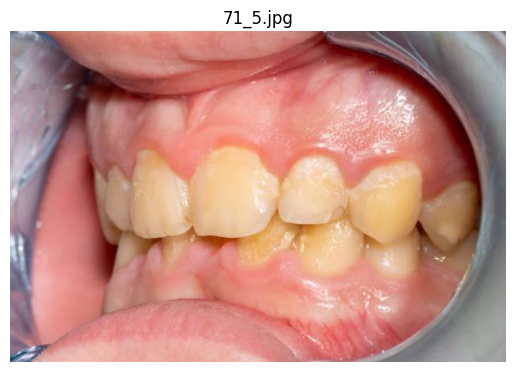

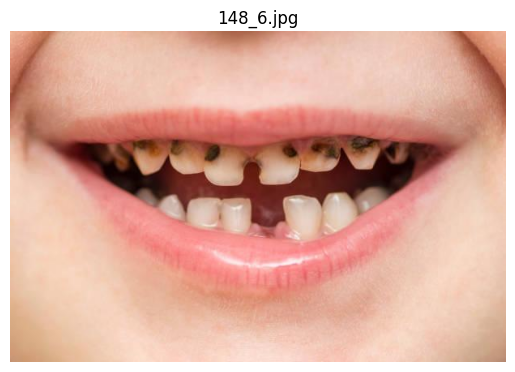

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os

sample_images = os.listdir(os.path.join(dataset_path, "/content/dataset/TRAIN/Caries"))[:5]

for img_name in sample_images:
    img = cv2.imread(os.path.join(dataset_path, "/content/dataset/TRAIN/Caries", img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(img_name)
    plt.axis("off")
    plt.show()

In [ ]:

dimensions = []
for root, dirs, files in os.walk("/content/dataset/TRAIN"):
    for file in files:
        img = cv2.imread(os.path.join(root, file))
        if img is not None:
            dimensions.append(img.shape)

print("Sample dimensions:", dimensions[:5])

Sample dimensions: [(424, 612, 3), (190, 266, 3), (196, 257, 3), (408, 612, 3), (408, 612, 3)]


In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

In [ ]:
image_size = 224

# Transformations for training and testing
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
train_path = "/content/dataset/TRAIN"
test_path = "/content/dataset/TEST"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

In [ ]:
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))

# Classes
print("Classes:", train_dataset.classes)

Number of training samples: 1486
Number of testing samples: 408
Classes: ['Caries', 'Gingivitis']


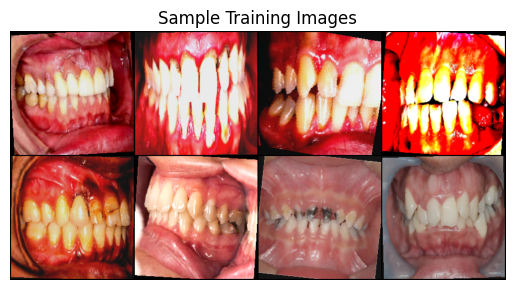

In [ ]:
import matplotlib.pyplot as plt
import torchvision

# Display a batch of images
images, labels = next(iter(train_loader))

# Unnormalize for display
def unnormalize(img):
    return img * 0.5 + 0.5

grid = torchvision.utils.make_grid([unnormalize(img) for img in images[:8]], nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.title("Sample Training Images")
plt.axis("off")
plt.show()

In [ ]:
pip install torch torchvision


In [ ]:
pip install pretrainedmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b946dd4776848d4296a1931b04c165aae079a0000d52c1119261fbd3642d2aa7
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built pretrainedmodels


In [ ]:
import torch
import pretrainedmodels
from torch import nn

In [ ]:
import timm
model = timm.create_model('inception_resnet_v2', pretrained=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

In [ ]:
import timm
import torch.nn as nn

model = timm.create_model('inception_resnet_v2', pretrained=True)
num_classes = len(train_dataset.classes)
model.classif = nn.Linear(model.classif.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Training phase
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        print(f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

        # Step the scheduler
        if scheduler:
            scheduler.step()

    print("Training complete")

In [ ]:
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
Train Loss: 0.2601, Train Accuracy: 0.9024
Val Loss: 0.3770, Val Accuracy: 0.9118
Epoch 2/10
Train Loss: 0.1036, Train Accuracy: 0.9664
Val Loss: 0.1410, Val Accuracy: 0.9534
Epoch 3/10
Train Loss: 0.0842, Train Accuracy: 0.9724
Val Loss: 0.0766, Val Accuracy: 0.9706
Epoch 4/10
Train Loss: 0.0803, Train Accuracy: 0.9744
Val Loss: 0.1862, Val Accuracy: 0.9510
Epoch 5/10
Train Loss: 0.0593, Train Accuracy: 0.9771
Val Loss: 0.1048, Val Accuracy: 0.9804
Epoch 6/10
Train Loss: 0.0451, Train Accuracy: 0.9825
Val Loss: 0.1190, Val Accuracy: 0.9681
Epoch 7/10
Train Loss: 0.0497, Train Accuracy: 0.9805
Val Loss: 0.0977, Val Accuracy: 0.9779
Epoch 8/10
Train Loss: 0.0411, Train Accuracy: 0.9845
Val Loss: 0.1263, Val Accuracy: 0.9681
Epoch 9/10
Train Loss: 0.0385, Train Accuracy: 0.9838
Val Loss: 0.1243, Val Accuracy: 0.9755
Epoch 10/10
Train Loss: 0.0377, Train Accuracy: 0.9859
Val Loss: 0.1317, Val Accuracy: 0.9681
Training complete


In [ ]:
torch.save(model.state_dict(), "inception_resnet_v2_model.pth")


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
def predict_image(image_path, model, transform):
    # Load image
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    # Make prediction
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # Map prediction to class name
    predicted_class = train_dataset.classes[predicted.item()]
    return predicted_class

# Example: Test on a single image
image_path = "/content/dataset/TEST/Gingivitis/113_1.jpg"
predicted_class = predict_image(image_path, model, test_transform)
print(f"Predicted Class: {predicted_class}")

Predicted Class: Gingivitis


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Initialize variables
all_preds = []
all_labels = []

# Iterate over the test loader
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

# Classification report
class_report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)
print("Classification Report:\n", class_report)

Confusion Matrix:
 [[203   1]
 [ 12 192]]
Classification Report:
               precision    recall  f1-score   support

      Caries       0.94      1.00      0.97       204
  Gingivitis       0.99      0.94      0.97       204

    accuracy                           0.97       408
   macro avg       0.97      0.97      0.97       408
weighted avg       0.97      0.97      0.97       408



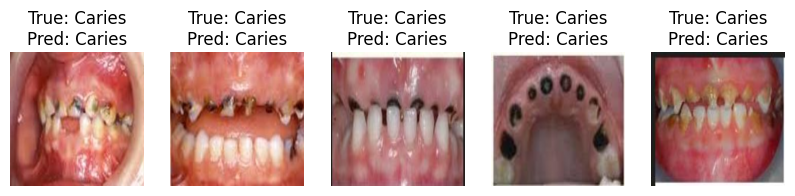

In [ ]:
import matplotlib.pyplot as plt

def display_predictions(loader, model, transform, num_images=5):
    model.eval()
    images_shown = 0

    plt.figure(figsize=(10, 10))
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if images_shown >= num_images:
                break

            # Unnormalize and display
            img = images[i].cpu().numpy().transpose((1, 2, 0))
            img = img * 0.5 + 0.5  # Unnormalize
            plt.subplot(1, num_images, images_shown + 1)
            plt.imshow(img)
            plt.title(f"True: {train_dataset.classes[labels[i]]}\nPred: {train_dataset.classes[predicted[i]]}")
            plt.axis("off")

            images_shown += 1

        if images_shown >= num_images:
            break

    plt.show()

# Example: Display predictions
display_predictions(test_loader, model, test_transform, num_images=5)